# Import libraries


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import os
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Dataset

In [51]:
print('# of real Ruqaa images: ', len(os.listdir('/content/rufa/real/ruqaa/')))
print('# of real Farsi images: ', len(os.listdir('/content/rufa/real/farsi/')))
print('# synthesized Ruqaa: ', len(os.listdir('/content/rufa/synth/ruqaa/')))
print('# synthesized Farsi: ', len(os.listdir('/content/rufa/synth/farsi/')))

# of real Ruqaa images:  260
# of real Farsi images:  256
# synthesized Ruqaa:  20000
# synthesized Farsi:  20000


In [52]:
synth_dir = Path('/content/rufa/synth')
real_dir = Path('/content/rufa/real')

CLASS_NAMES = np.array([item.name for item in real_dir.glob('*')])
CLASS_NAMES

array(['farsi', 'ruqaa'], dtype='<U5')

In [53]:
data_dir_train = '/content/rufa/synth'
data_dir_test = '/content/rufa/real'

In [54]:
# Defining variables
batch_size = 10
img_height = 100
img_width = 100

# Train, test split


In [55]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode='categorical',
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 40000 files belonging to 2 classes.


In [56]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  label_mode='categorical',
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 516 files belonging to 2 classes.


In [57]:
class_names = train_ds.class_names
print(class_names)

['farsi', 'ruqaa']


# Visualize the data

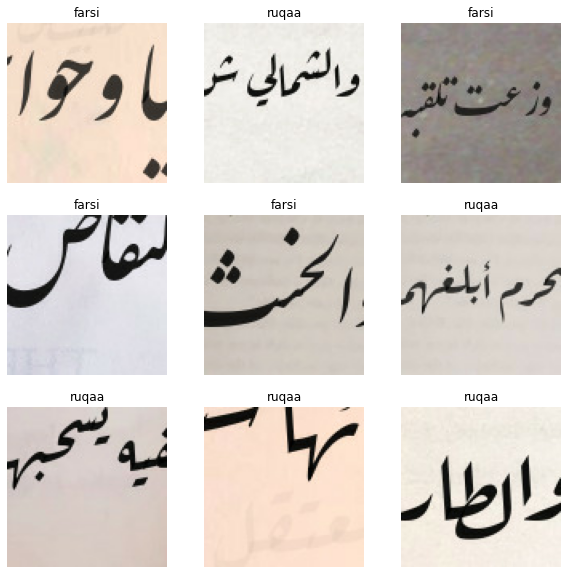

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

# Model

In [92]:
input_shape=(img_height, img_width, 3)
output_shape = num_classes= len(class_names)

In [93]:
def cnn(input_shape,output_shape):
  model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3,  activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3,  activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(units=num_classes, activation='softmax')
])
  return model

In [60]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 23, 23, 16)       

In [61]:
epochs = 8
callbacks = None

In [62]:
model.compile(optimizer='adam', 
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

# Train

In [63]:
history = model.fit(train_ds, epochs =epochs, callbacks = None);

Epoch 1/8
4000/4000 [==============================] - 29s 7ms/step - loss: 0.1550 - accuracy: 0.9294
Epoch 2/8
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0388 - accuracy: 0.9862
Epoch 3/8
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0229 - accuracy: 0.9913
Epoch 4/8
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0180 - accuracy: 0.9937
Epoch 5/8
4000/4000 [==============================] - 30s 7ms/step - loss: 0.0137 - accuracy: 0.9953
Epoch 6/8
4000/4000 [==============================] - 29s 7ms/step - loss: 0.0120 - accuracy: 0.9961
Epoch 7/8
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0124 - accuracy: 0.9961
Epoch 8/8
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0082 - accuracy: 0.9973


# Evaluate

In [64]:
test_score = model.evaluate(test_ds)

52/52 [==============================] - 0s 4ms/step - loss: 0.1886 - accuracy: 0.9477


# Classification Evaluation


In [68]:
 #Calculating prediction and ground truth on Test dataset
y_true = []
for t, tensor in test_ds.unbatch().enumerate():
    array = tensor[1].numpy()
    y_true.append(array.argmax(axis=0))

y_predict = model.predict(test_ds).argmax(axis=1)

# Confusion Matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_true, y_predict)
print(cm,'\n')
accuracy_score(y_true, y_predict)

# Precision and recall
from sklearn.metrics import classification_report
print(classification_report(y_true,y_predict))

52/52 [==============================] - 1s 7ms/step
[[231  25]
 [  2 258]] 

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       256
           1       0.91      0.99      0.95       260

    accuracy                           0.95       516
   macro avg       0.95      0.95      0.95       516
weighted avg       0.95      0.95      0.95       516



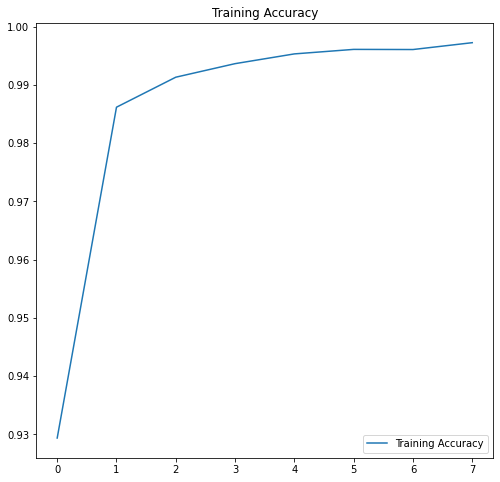

In [74]:
accuracy = history.history['accuracy']

epoch_range = range(epochs)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, accuracy, label='Training Accuracy')
plt.title('Training Accuracy')

plt.legend(loc='lower right')

plt.show()

# Save the Model

In [76]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


# Load the model 

In [77]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

# Predict on new data


In [84]:
pic = 'Ruqaa'

In [85]:
import numpy as np
from keras.utils import load_img, img_to_array
#test_image = load_img(f'/Users/lucashawranke/Downloads/birds/data/images_to_test/{pic}.jpg', target_size = (img_height, img_width))
test_image = load_img(f'test/{pic}.jpg', target_size = (img_height, img_width))

test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
predictions = model.predict(test_image)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 33ms/step
This image most likely belongs to ruqaa with a 73.11 percent confidence.


#Visualizing our CNN architecture


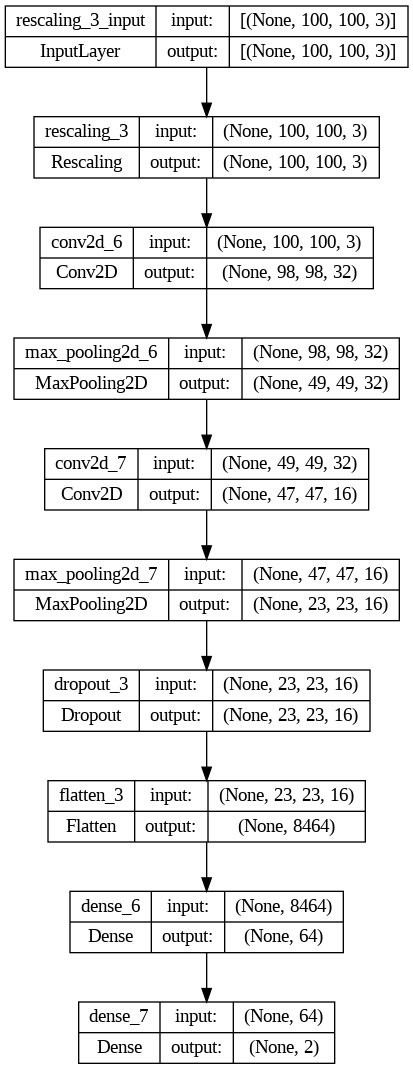

In [86]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")